# BREXIT June 23rd 2016

<img src="files/Images/Article-Brexit1.png">
<img src="files/Images/Article-Brexit2.png">

# Import data from yahoo

In [230]:
from pandas_datareader import data
%matplotlib inline  
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys,traceback
import h5py
from PIL import Image
import math
from datetime import datetime

In [2]:
# Define which online source one should use
data_source = 'yahoo'

# We would like all available data from 2000-6-23 until 2017-7-23. the event date is 2017-6-23
start_date = '2000-6-23'
end_date = '2017-8-24'

# User pandas_reader.data.DataReader to load the desired data. As simple as that.
ts = (data.DataReader('^FTSE', data_source, start_date, end_date)['Adj Close']).dropna()
ts[:10]

Date
2000-06-22    6413.799805
2000-06-23    6391.500000
2000-06-26    6405.200195
2000-06-27    6375.299805
2000-06-28    6313.500000
2000-06-29    6239.000000
2000-06-30    6312.700195
2000-07-03    6470.399902
2000-07-04    6417.000000
2000-07-05    6382.500000
Name: Adj Close, dtype: float64

# Define methods for plotting and summarizing the gain

### Gain percentage formula :   
\begin{align}
\ \mathbf{X  = \frac{(V_2-V_1)}{V_1} }
\end{align}

In [86]:
def plotImage(path,size=None):
    img = Image.open(path)
    plt.tick_params(labelbottom='off',labelleft='off',bottom='off',top='off',left='off',right='off')
    if size:
        plt.rcParams["figure.figsize"] = size
    plt.imshow(img)

In [186]:
def plotDataWithEvent(data,event_date,x_label,y_label,title):
    plt.plot(data[:event_date].index,data[:event_date], label='Before the event at '+event_date)
    plt.plot(data[event_date:].index,data[event_date:], label='After the event at '+event_date)
    plt.rcParams["figure.figsize"] = [15.0,10.0]
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(loc='upper left')
    plt.title(title)
    plt.show()

In [78]:
def plotData(data,x_label,y_label,title,ylim=None):
    plt.rcParams["figure.figsize"] = [15.0,10.0]
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend('price legend')
    if ylim:
        plt.ylim(ylim[0],ylim[1])
    data.plot()

In [228]:
def getData(stock_name, start_date, end_date, source='yahoo'):
    # Convert date parameters into datetime type
    start = datetime.strptime(start_date, '%Y-%m-%d')
    end = datetime.strptime(end_date, '%Y-%m-%d')
    
    # Get data using an API
    ts = data.DataReader(stock_name, source, start, end)['Adj Close']
    
    return ts

In [194]:
def gainPercentage(ts):
    ts_gain = pd.DataFrame(columns=['gain'])
    data = ts[1:]
    previous_index = ts.index[0]
    for index_ts, row_ts in data.iteritems():
        gain_value = (ts[index_ts] - ts[previous_index])/ts[previous_index]
        ts_gain.loc[index_ts] = gain_value
        previous_index = index_ts
    return ts_gain.gain


In [195]:
def dropOutliers(train_data,sd_coef):
    data_gain = gainPercentage(train_data)
    mean_gain = np.mean(data_gain.values)
    risk = np.std(data_gain.values)
    
    for gain,index in zip(data_gain.values,data_gain.index):
        if gain > mean_gain + (risk*sd_coef) or gain < mean_gain - (risk*sd_coef):
            if data_gain[0] == gain:
                data_gain[0] = data_gain[1]
            else :
                if data_gain[-1] == gain:
                    data_gain[-1] = data_gain[-2]
                else:
                    prev_val = data_gain.shift(1)[data_gain.index.get_loc(index)]
                    next_val = data_gain.shift(-1)[data_gain.index.get_loc(index)]
                    data_gain[data_gain.index.get_loc(index)] = (prev_val + next_val ) / 2
        
    return data_gain
            
    

# Plot gain with and without outliers

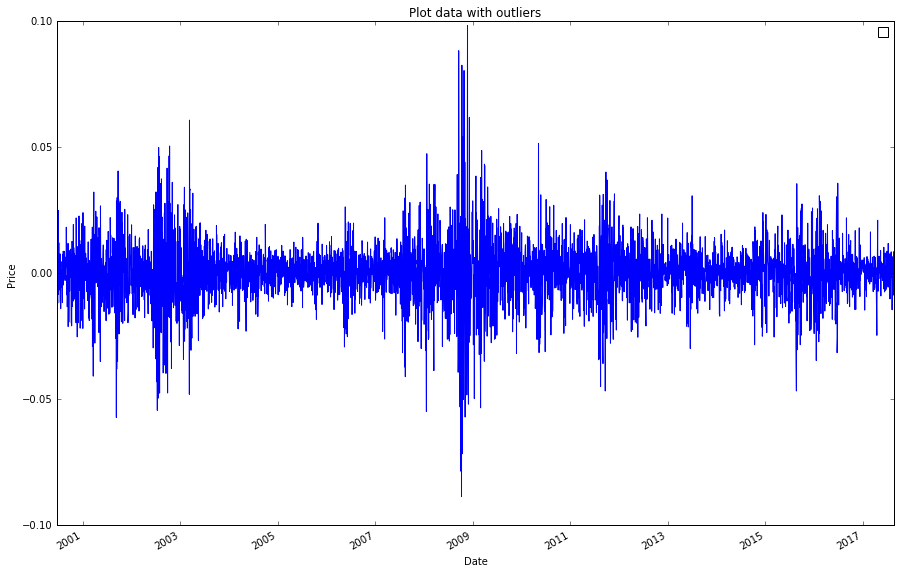

In [61]:
plotData(gainPercentage(ts),'Date','Price','Plot data with outliers')

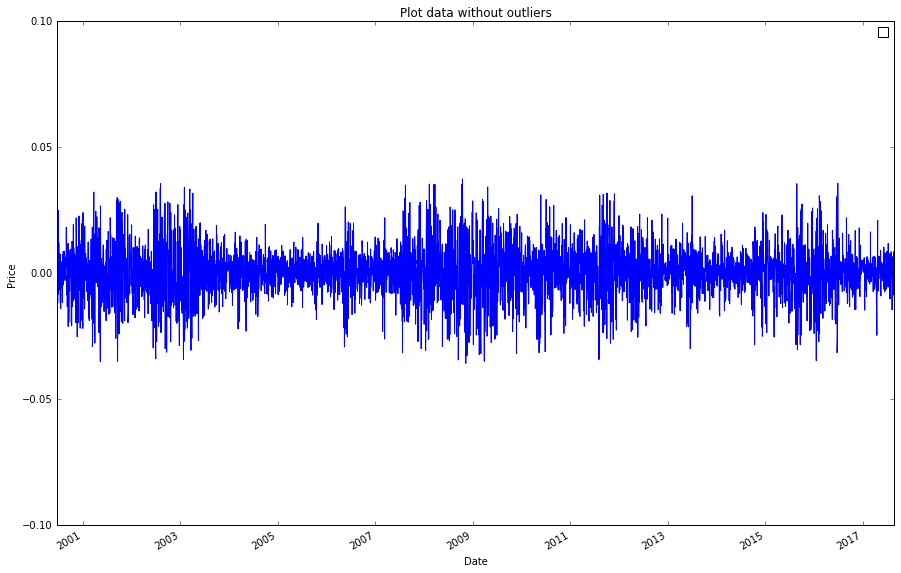

In [68]:
plotData(dropOutliers(ts,3),'Date','Price','Plot data without outliers',ylim=[-0.1,0.1])

# Build the Arima Model

**ARIMA** (AutoRegressive Integrated Moving Average) models seek to determine each value in the temporal series based on the values preceding it:
\begin{align}
y_t = f(y_{t-1}, y_{t-2}, …)
\end{align}

An **ARIMA** model is labeled as **ARIMA model (p, d, q)**, where: 
- **p** is the number of auto-regressive terms
- **d** is the number of differences
- **q** is the number of moving averages


* **Differentiation:**

**ARIMA** models assume that we are working on a stationary series. This means that the series average is constant over time, as well as its variance. The best method to eliminate any tendency is to differentiate, that is, to replace the original series by the series of adjacent differences.
\begin{align}
y_t - y_{t-1} = \mu + \epsilon_t \
\end{align}

* **Auto-Regression:**

Auto-regressive models assume that $y_t$ is a linear function of the previous values.
\begin{align}
y_t = \mu + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \phi_3 y_{t-3} + \epsilon_t
\end{align}
* **Auto-Regression:**

Auto-regressive models assume that $y_t$ is a linear function of the previous values.
\begin{align}
y_t = \mu + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \phi_3 y_{t-3} + \epsilon_t
\end{align}

* **Moving average **

Moving average models suggest that the series has fluctuations around a mean value.
The best estimate is then considered as the weighted average of a number of previous values:
\begin{align}
y_t = \mu - \theta_1 \epsilon_ {t-1} - \theta_2 \epsilon_ {t-2} - \theta_3 \epsilon_{t-3} + \epsilon_t
\end{align}

In [188]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings

In [189]:
def trainTimeSeries(train_data,validation_data,p_values,d_values,q_values):
    
    configs = {}
    for p in p_values:
        for d in d_values:
            for q in q_values:
                try:
                    arima_order = (p,d,q)
                    history = train_data.values.tolist()
                    dates = train_data.index.tolist()
                    predictions = list()
                    exo = (train_data.index.weekday+1).tolist()
                    for value,index in zip(validation_data.values,validation_data.index):
                        model = ARIMA(history, order=arima_order,dates=dates)
                        model_fit = model.fit(disp=0)
                        yhat = model_fit.forecast()[0]
                        predictions.append(yhat)
                        history.append(value)
                        dates.append(index)
                        exo.append(index.weekday()+1)
                    error = mean_squared_error(validation_data.values, predictions)
                    configs[arima_order]=error
                    print(arima_order," ---> ",error)
                except:
                    #print ("Unexpected error:", sys.exc_info()[0])
                    #traceback.print_exc(file=sys.stdout)
                    continue
    
    best_config = min(zip(list(configs.values()), list(configs.keys())))
    print("best config  : ",best_config)
    fit_data = train_data.append(validation_data)
    model = ARIMA(fit_data.values.tolist(), order=best_config[1],dates=fit_data.index.tolist()).fit(disp=0)
    #return ARIMA(fit_data.values.tolist(), order=best_config,dates=fit_data.index.tolist()).fit(disp=0,method='css'),
    return  best_config[1]


In [190]:
def predictSerie(data,arima_order,predicted_dates):

    history = data.values.tolist()
    dates = data.index.tolist()
    predictions = list()
    for index in predicted_dates:
        model = ARIMA(history, order=arima_order,dates=dates)
        model_fit = model.fit(disp=0,method='css')
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(yhat)
        dates.append(index)
    
    return pd.Series(data=predictions,index=predicted_dates)
      

### Arima with real data

In [191]:
#gain_ts = gainPercentage(ts)
gain_ts = ts
train_data = gain_ts['2015-04-23':'2016-04-23']
validation_data = gain_ts['2016-04-23':'2016-05-23']
p_values = range(0,5)
d_values = range(1,3)
q_values = range(1,2)

warnings.filterwarnings("ignore")
best_order = trainTimeSeries(train_data,validation_data,p_values,d_values,q_values)


(0, 1, 1)  --->  2454.37067427
(0, 2, 1)  --->  2608.73388646
(1, 2, 1)  --->  2612.19381776
(2, 1, 1)  --->  2431.55968635
(2, 2, 1)  --->  2632.52034352
(3, 1, 1)  --->  2478.81257315
(3, 2, 1)  --->  2685.40259706
(4, 1, 1)  --->  2440.72702902
(4, 2, 1)  --->  2602.15328843
best config  :  (2431.5596863502706, (2, 1, 1))


In [192]:
predictions = predictSerie(gain_ts['2015-04-23':'2016-05-23'],best_order,gain_ts['2016-05-23':'2016-06-23'].index.tolist())
predictions

2016-05-23    [6115.56853077]
2016-05-24    [6123.93097085]
2016-05-25    [6115.74595093]
2016-05-26    [6113.34639721]
2016-05-27    [6109.71868541]
2016-05-31    [6106.06618284]
2016-06-01    [6102.58195922]
2016-06-02    [6099.00509848]
2016-06-03    [6095.46002528]
2016-06-06    [6091.90854383]
2016-06-07     [6088.3566923]
2016-06-08    [6084.80524978]
2016-06-09      [6081.253744]
2016-06-10    [6077.70258973]
2016-06-13    [6074.15161565]
2016-06-14    [6070.60033794]
2016-06-15    [6067.04880764]
2016-06-16    [6063.49721941]
2016-06-17    [6059.94565139]
2016-06-20    [6056.39456998]
2016-06-21    [6052.84323013]
2016-06-22    [6049.29204919]
2016-06-23    [6045.74083813]
dtype: object

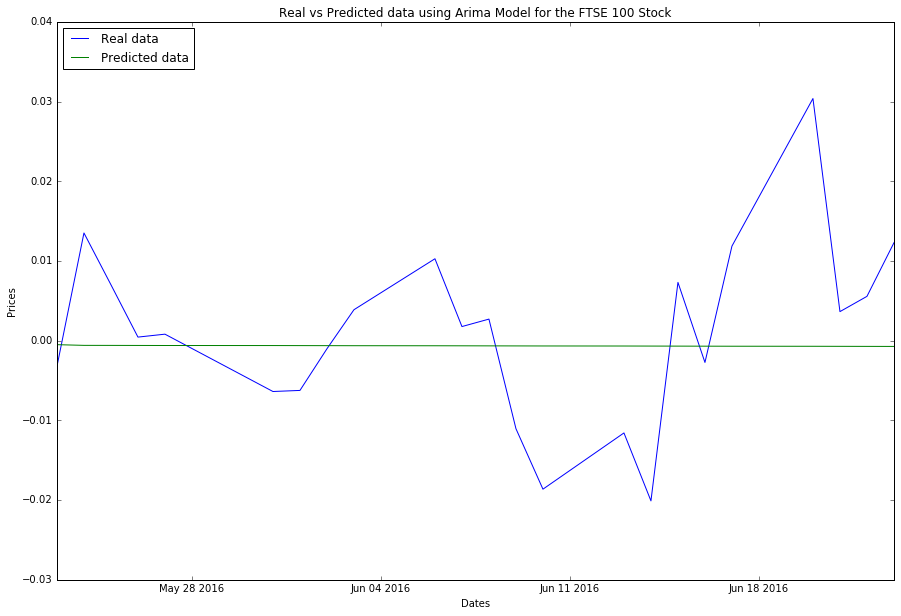

In [219]:
plt.plot(gain_ts['2016-05-23':'2016-06-23'].index,gain_ts['2016-05-23':'2016-06-23'].values,label="Real data")
plt.plot(predictions.index,predictions.values,label="Predicted data")
plt.rcParams["figure.figsize"] = [15.0,10.0]
plt.xlabel("Dates")
plt.ylabel("Prices")
plt.title("Real vs Predicted data using Arima Model for the FTSE 100 Stock")
plt.legend(loc='upper left')
#plt.ylim(-0.1,0.1)
plt.show()

### Arima with gain percentage data ( with no outliers )

In [198]:
gain_ts = gainPercentage(ts)
train_data = gain_ts['2015-04-23':'2016-04-23']
validation_data = gain_ts['2016-04-23':'2016-05-23']
p_values = range(0,5)
d_values = range(1,3)
q_values = range(1,2)

warnings.filterwarnings("ignore")
best_order = trainTimeSeries(train_data,validation_data,p_values,d_values,q_values)

predictions = predictSerie(gain_ts['2015-04-23':'2016-05-23'],best_order,gain_ts['2016-05-23':'2016-06-23'].index.tolist())
predictions

(0, 1, 1)  --->  6.89771441866e-05
(0, 2, 1)  --->  0.00015082995124
(1, 1, 1)  --->  6.7986109264e-05
(2, 1, 1)  --->  6.97938241846e-05
(2, 2, 1)  --->  9.9530450638e-05
(4, 1, 1)  --->  7.1505691742e-05
(4, 2, 1)  --->  7.98353696326e-05
best config  :  (6.798610926397563e-05, (1, 1, 1))


2016-05-23     [-0.00050196520977]
2016-05-24    [-0.000590212468238]
2016-05-25    [-0.000594389937636]
2016-05-26    [-0.000600943018598]
2016-05-27     [-0.00060739988547]
2016-05-31     [-0.00061396029541]
2016-06-01    [-0.000620407966905]
2016-06-02    [-0.000626775183815]
2016-06-03    [-0.000633187916774]
2016-06-06    [-0.000639710552373]
2016-06-07    [-0.000645950804206]
2016-06-08    [-0.000652924837998]
2016-06-09    [-0.000659263937288]
2016-06-10    [-0.000665793972442]
2016-06-13    [-0.000672382581122]
2016-06-14    [-0.000678881462715]
2016-06-15    [-0.000685302951107]
2016-06-16    [-0.000691879718581]
2016-06-17     [-0.00069838647345]
2016-06-20    [-0.000704835841615]
2016-06-21    [-0.000711296846812]
2016-06-22    [-0.000717867804686]
2016-06-23    [-0.000724110077159]
dtype: object

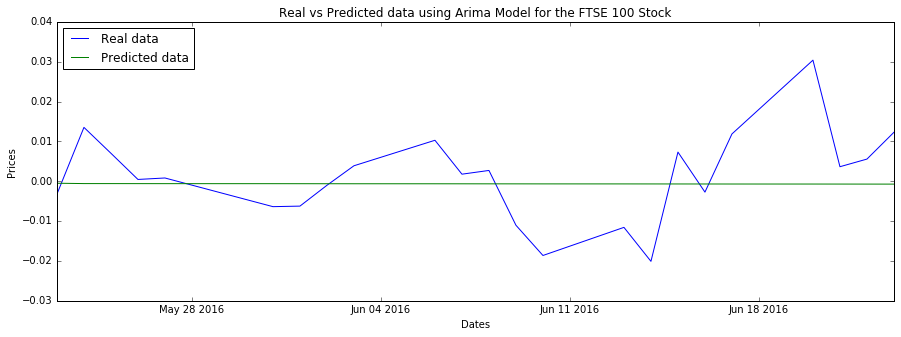

In [218]:
plt.plot(gain_ts['2016-05-23':'2016-06-23'].index,gain_ts['2016-05-23':'2016-06-23'].values,label="Real data")
plt.plot(predictions.index,predictions.values,label="Predicted data")
plt.rcParams["figure.figsize"] = [15.0,10.0]
plt.xlabel("Dates")
plt.ylabel("Prices")
plt.title("Real vs Predicted data using Arima Model for the FTSE 100 Stock")
plt.legend(loc='upper left')
#plt.ylim(-0.1,0.1)
plt.show()

# LSTM with multiple outputs

** LSTMs **

Traditional neural networks can’t persist information, and it seems like a major shortcoming.
Recurrent neural networks address this issue. They are networks with loops in them, allowing information to persist.

<img src="files/Images/RNN-unrolled.png" width ='50%'>

LSTMs are a very special kind of recurrent neural networks which works, for many tasks, much better than the standard RNN version. They are capable of learning long-term dependencies.

<img src="files/Images/LSTM3-chain.png" width ='50%'>

## The LSTM Model architecture

<img src="files/Images/LSTM.png" width ='70%'>

In [3]:
# LSTM for international airline passengers problem with regression framing
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout,TimeDistributed
from keras.layers import LSTM, GRU
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_squared_log_error
from keras.callbacks import EarlyStopping

# convert an array of values into a dataset matrix
# dataset is created using sliding windows with a size of 1
def create_dataset(dataset, look_back=1,output_size=10,window_size=1):
    dataX, dataY = [], []
    for i in np.arange(0,len(dataset)-look_back-1-output_size, window_size): 
    #for i in range(len(dataset)-look_back-1-output_size):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back:i + look_back+output_size, 0])
    return numpy.array(dataX), numpy.array(dataY)



Using TensorFlow backend.


In [4]:
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset before the event
dataset = ts[:'2016-6-23'].values.reshape(-1,1)
dataset = dataset.astype('float32')
# normalize the dataset
#here we're using MinMax scaller , we can use standard scaller too
#scaler = StandardScaler()
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
dataset

array([[ 0.81917733],
       [ 0.813335  ],
       [ 0.81692427],
       ..., 
       [ 0.77013355],
       [ 0.77919835],
       [ 0.79934508]], dtype=float32)

### Building the dataset using sliding window
<img src="files/Images/window.png" width ='70%'>

In [151]:
# split into train and test sets
train_size = int(len(dataset) * 0.85)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
# look back is fixed to 300 => 13 months
look_back = 60
#size of Y samples
output_size=3
window_size = 1
trainX, trainY = create_dataset(train, look_back,output_size=output_size,window_size=window_size)
testX, testY = create_dataset(test, look_back,output_size=output_size,window_size=window_size)
#print(trainX[:2])
print(trainY.shape)

(3373, 3)


In [152]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (-1, look_back, 1))
testX = numpy.reshape(testX, (-1, look_back, 1))

trainY = numpy.reshape(trainY, (-1, output_size))
testY = numpy.reshape(testY, (-1, output_size))
print(testY.shape)

(543, 3)


In [153]:
model = Sequential()
model.add(LSTM(80,activation='relu', recurrent_activation='sigmoid', input_shape=(look_back, 1),return_sequences=False))
model.add(Dense(output_size))
#model.add(Activation('sigmoid'))

model.compile(loss='mean_squared_error', optimizer='adam')
early_stopping = EarlyStopping(monitor='loss', patience=4)
model.fit(trainX, trainY, epochs=100, batch_size=5,callbacks=[early_stopping], verbose=2)

Epoch 1/100
 - 31s - loss: 0.0098
Epoch 2/100
 - 29s - loss: 0.0012
Epoch 3/100
 - 33s - loss: 9.6629e-04
Epoch 4/100
 - 35s - loss: 8.1412e-04
Epoch 5/100
 - 29s - loss: 7.4447e-04
Epoch 6/100
 - 32s - loss: 6.8123e-04
Epoch 7/100
 - 30s - loss: 6.6471e-04
Epoch 8/100
 - 30s - loss: 6.4514e-04
Epoch 9/100
 - 30s - loss: 6.2279e-04
Epoch 10/100
 - 29s - loss: 6.4173e-04
Epoch 11/100
 - 31s - loss: 6.1142e-04
Epoch 12/100
 - 30s - loss: 5.8563e-04
Epoch 13/100
 - 29s - loss: 5.8886e-04
Epoch 14/100
 - 30s - loss: 5.7667e-04
Epoch 15/100
 - 29s - loss: 5.7375e-04
Epoch 16/100
 - 29s - loss: 5.6963e-04
Epoch 17/100
 - 29s - loss: 5.7322e-04
Epoch 18/100
 - 29s - loss: 5.6578e-04
Epoch 19/100
 - 29s - loss: 5.5767e-04
Epoch 20/100
 - 29s - loss: 5.6527e-04
Epoch 21/100
 - 29s - loss: 5.5917e-04
Epoch 22/100
 - 30s - loss: 5.6312e-04
Epoch 23/100
 - 29s - loss: 5.5492e-04
Epoch 24/100
 - 31s - loss: 5.5119e-04
Epoch 25/100
 - 30s - loss: 5.5973e-04
Epoch 26/100
 - 29s - loss: 5.5499e-04
Epo

In [154]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)

In [155]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY,trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 86.97 RMSE
Test Score: 92.85 RMSE


In [361]:
#save the model into a h5 format (an hdfs format), pickle is not compatible with keras objects
import h5py
name = "h5-models/FTSE_best_model_3_with_loss_4-4590e-04-batch-5.h5"
model.save(name)

# Plot the training set

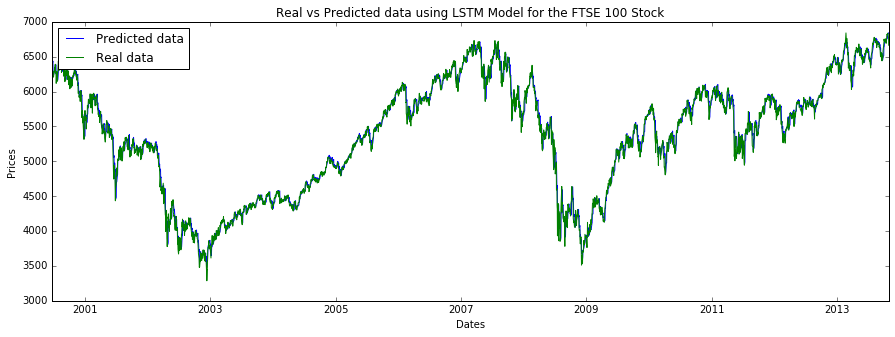

 Correlation between predicted values and real values for training set is :  0.99423043627


In [217]:
predicted_train_windows = list()
train_windows = list()

if window_size == 1:
    for i in np.arange(0,len(trainPredict),output_size):
        predicted_train_windows.append(trainPredict[i])
        train_windows.append(trainY[i])
else:
    for i in np.arange(0,len(trainPredict)):
        predicted_train_windows.append(trainPredict[i])
        train_windows.append(trainY[i])

predicted_train_windows = numpy.asarray(predicted_train_windows).flatten()
train_windows = numpy.asarray(train_windows).flatten()
plt.plot(ts[:'2016-6-23'].index[:len(predicted_train_windows)],predicted_train_windows,label="Predicted data")
plt.plot(ts[:'2016-6-23'].index[:len(predicted_train_windows)],train_windows,label="Real data")
plt.rcParams["figure.figsize"] = [15.0,5.0]
plt.xlabel("Dates")
plt.ylabel("Prices")
plt.title("Real vs Predicted data using LSTM Model for the FTSE 100 Stock")
plt.legend(loc='upper left')
#plt.axis(['2016-5-23','2016-7-23',6000,6500])
plt.show()
print(" Correlation between predicted values and real values for training set is : ",np.corrcoef(predicted_train_windows,train_windows)[0][1])

# Plot the test set

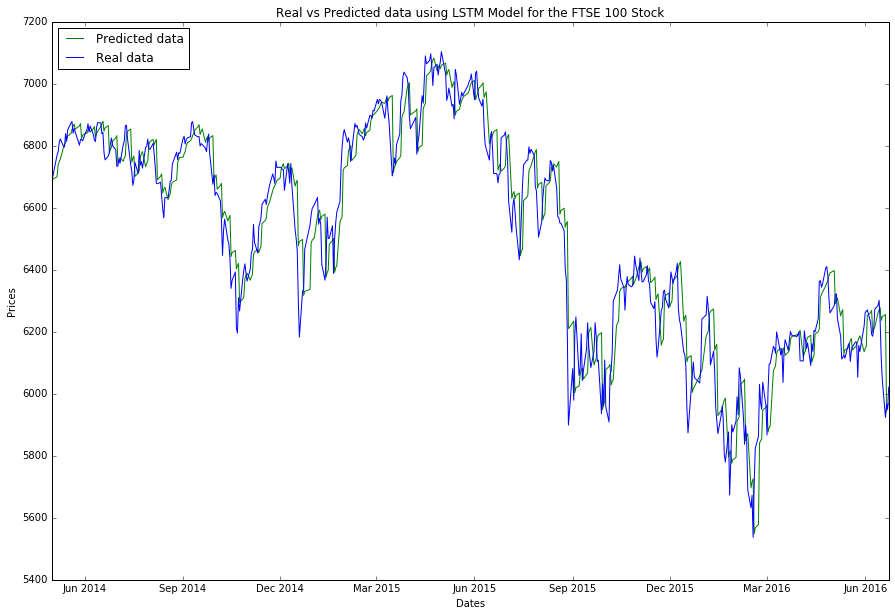

 Correlation between predicted values and real values for test set is :  0.962059069538


In [220]:
predicted_windows = list()
test_windows = list()

if window_size == 1:
    for i in np.arange(0,len(testPredict),output_size):
        predicted_windows.append(testPredict[i])
        test_windows.append(testY[i])
else:
    for i in np.arange(0,len(testPredict)):
        predicted_windows.append(testPredict[i])
        test_windows.append(testY[i])

predicted_windows = numpy.asarray(predicted_windows).flatten()
test_windows = numpy.asarray(test_windows).flatten()
plt.plot(ts[:'2016-6-23'].index[-len(predicted_windows):],predicted_windows,color='g',label="Predicted data")
plt.plot(ts[:'2016-6-23'].index[-len(predicted_windows):],test_windows,color='b',label="Real data")
plt.rcParams["figure.figsize"] = [15.0,10.0]
plt.xlabel("Dates")
plt.ylabel("Prices")
plt.title("Real vs Predicted data using LSTM Model for the FTSE 100 Stock")
plt.legend(loc='upper left')
#plt.axis(['2016-5-23','2016-7-23',6000,6500])
plt.show()
print(" Correlation between predicted values and real values for test set is : ",np.corrcoef(predicted_windows,test_windows)[0][1])

### Predicting 1 week after the Brexit event on June 23rd 2016

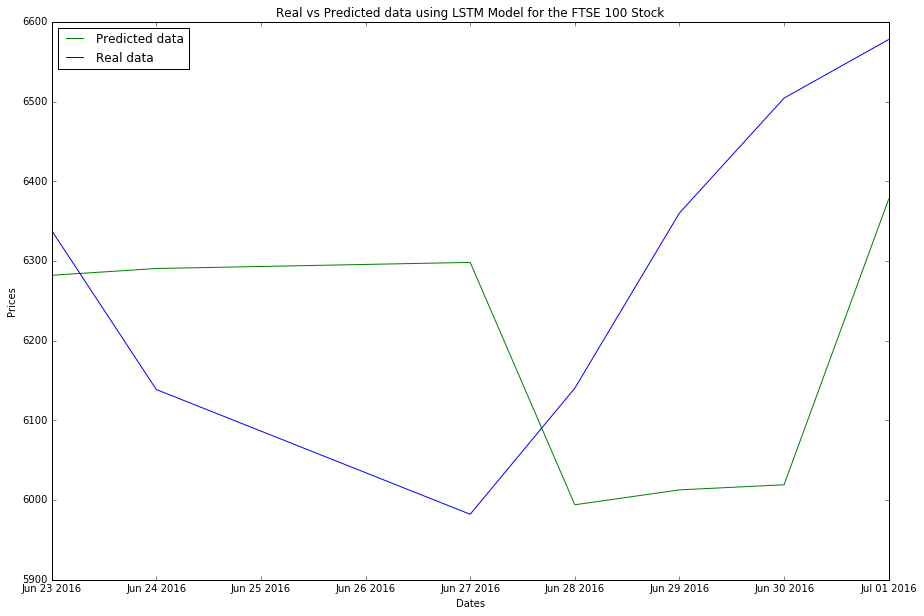

 Correlation between predicted values and real values for event set is :  -0.0455823937967


In [221]:
#history_base = list(dataset[-look_back:].flatten())
history_base = list(scaler.transform((ts[:'2016-6-23'])[-look_back:].values.reshape(1, -1).astype('float32')).flatten())
event = list(scaler.transform(ts['2016-6-23':'2016-7-1'].values.reshape(1, -1).astype('float32')).flatten())
predicted_event_windows = list()

#append first element
predicted_event_windows.append(scaler.inverse_transform(model.predict(np.asarray(history_base).reshape(-1, look_back, 1))))

for i in np.arange(output_size,len(event), output_size):
    if i >= len(history_base):
        predicted_event_windows.append(scaler.inverse_transform(model.predict(np.asarray(event[i-look_back:i]).reshape(-1, look_back, 1))))
    else:
        predicted_event_windows.append(scaler.inverse_transform(model.predict(np.asarray(history_base[i:]+event[:i]).reshape(-1, look_back, 1))))

#flatten predictions
predicted_event_windows = np.asarray(predicted_event_windows).flatten() 
#inverse transform event values
event = scaler.inverse_transform(np.asarray(event).reshape(1, -1)).flatten() 

plt.plot(ts['2016-6-23':'2016-7-1'].index[:len(predicted_event_windows)],predicted_event_windows[:len(ts['2016-6-23':'2016-7-1'])],color='g',label="Predicted data")
plt.plot(ts['2016-6-23':'2016-7-1'].index[:len(predicted_event_windows)],event,color='b',label="Real data")
plt.rcParams["figure.figsize"] = [15.0,10.0]
plt.xlabel("Dates")
plt.ylabel("Prices")
plt.title("Real vs Predicted data using LSTM Model for the FTSE 100 Stock")
plt.legend(loc='upper left')
#plt.axis(['2016-5-23','2016-7-23',6000,6500])
plt.show()
print(" Correlation between predicted values and real values for event set is : ",np.corrcoef(predicted_event_windows[:len(event)],event)[0][1])

### Predicting 1 month after the Brexit event on June 23rd 2016

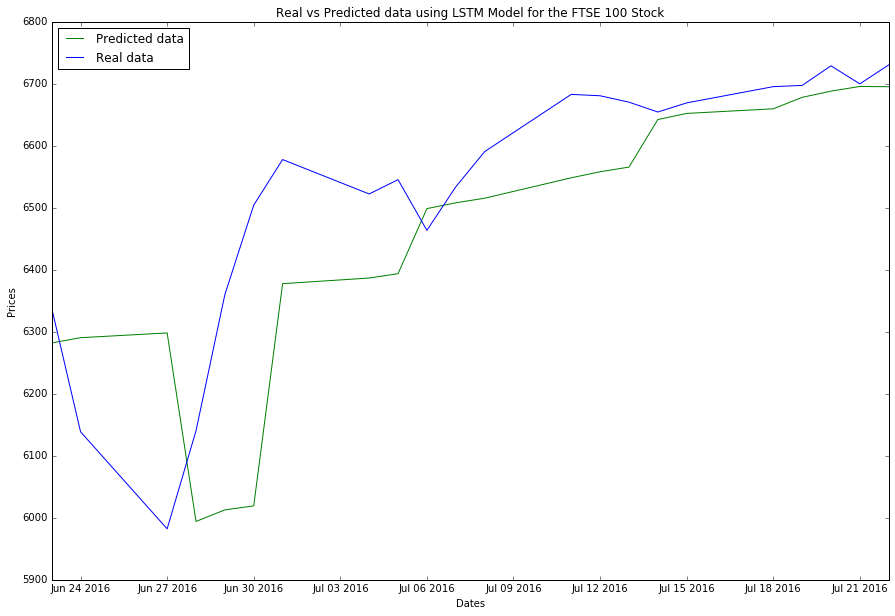

 Correlation between predicted values and real values for event set is :  0.744331399231


In [222]:
#history_base = list(dataset[-look_back:].flatten())
history_base = list(scaler.transform((ts[:'2016-6-23'])[-look_back:].values.reshape(1, -1).astype('float32')).flatten())
event = list(scaler.transform(ts['2016-6-23':'2016-7-23'].values.reshape(1, -1).astype('float32')).flatten())
predicted_event_windows = list()

#append first element
predicted_event_windows.append(scaler.inverse_transform(model.predict(np.asarray(history_base).reshape(-1, look_back, 1))))

for i in np.arange(output_size,len(event), output_size):
    if i >= len(history_base):
        predicted_event_windows.append(scaler.inverse_transform(model.predict(np.asarray(event[i-look_back:i]).reshape(-1, look_back, 1))))
    else:
        predicted_event_windows.append(scaler.inverse_transform(model.predict(np.asarray(history_base[i:]+event[:i]).reshape(-1, look_back, 1))))

#flatten predictions
predicted_event_windows = np.asarray(predicted_event_windows).flatten() 
#inverse transform event values
event = scaler.inverse_transform(np.asarray(event).reshape(1, -1)).flatten() 

plt.plot(ts['2016-6-23':'2016-7-23'].index[:len(predicted_event_windows)],predicted_event_windows[:len(ts['2016-6-23':'2016-7-23'])],color='g',label="Predicted data")
plt.plot(ts['2016-6-23':'2016-7-23'].index[:len(predicted_event_windows)],event,color='b',label="Real data")
plt.rcParams["figure.figsize"] = [15.0,10.0]
plt.xlabel("Dates")
plt.ylabel("Prices")
plt.title("Real vs Predicted data using LSTM Model for the FTSE 100 Stock")
plt.legend(loc='upper left')
#plt.axis(['2016-5-23','2016-7-23',6000,6500])
plt.show()
print(" Correlation between predicted values and real values for event set is : ",np.corrcoef(predicted_event_windows[:len(event)],event)[0][1])

### Predicting 6 months after the Brexit event on June 23rd 2016

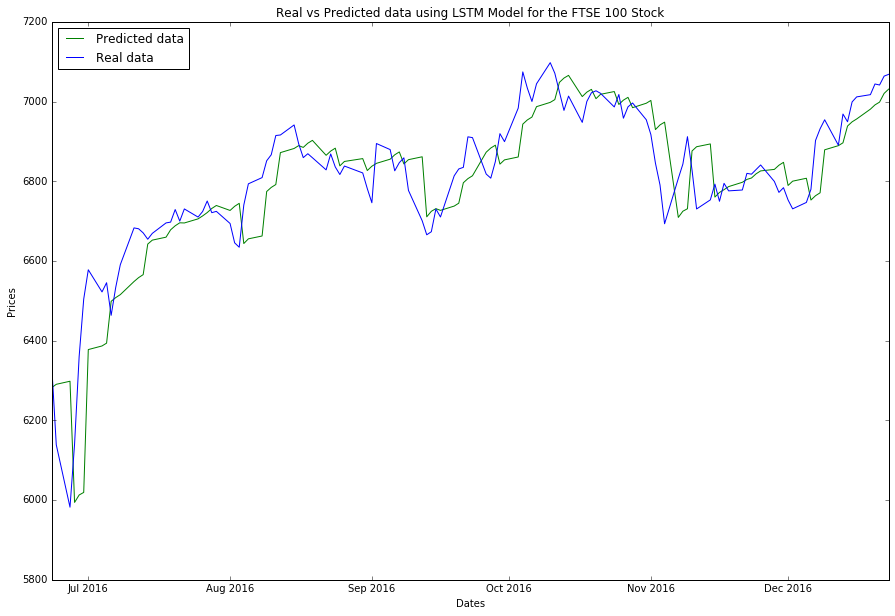

 Correlation between predicted values and real values for event set is :  0.879522758142


In [223]:
history_base = list(dataset[-look_back:].flatten())
event = list(scaler.transform(ts['2016-6-23':'2016-12-23'].values.reshape(1, -1).astype('float32')).flatten())
predicted_event_windows = list()

#append first element
predicted_event_windows.append(scaler.inverse_transform(model.predict(np.asarray(history_base).reshape(-1, look_back, 1))))

for i in np.arange(output_size,len(event), output_size):
    if i >= len(history_base):
        predicted_event_windows.append(scaler.inverse_transform(model.predict(np.asarray(event[i-look_back:i]).reshape(-1, look_back, 1))))
    else:
        predicted_event_windows.append(scaler.inverse_transform(model.predict(np.asarray(history_base[i:]+event[:i]).reshape(-1, look_back, 1))))

#flatten predictions
predicted_event_windows = np.asarray(predicted_event_windows).flatten() 
#inverse transform event values
event = scaler.inverse_transform(np.asarray(event).reshape(1, -1)).flatten() 

plt.plot(ts['2016-6-23':'2016-12-23'].index[:len(predicted_event_windows)],predicted_event_windows[:len(ts['2016-6-23':'2016-12-23'])],color='g',label="Predicted data")
plt.plot(ts['2016-6-23':'2016-12-23'].index[:len(predicted_event_windows)],event,color='b',label="Real data")
plt.rcParams["figure.figsize"] = [15.0,10.0]
plt.xlabel("Dates")
plt.ylabel("Prices")
plt.title("Real vs Predicted data using LSTM Model for the FTSE 100 Stock")
plt.legend(loc='upper left')
#plt.axis(['2016-5-23','2016-7-23',6000,6500])
plt.show()
print(" Correlation between predicted values and real values for event set is : ",np.corrcoef(predicted_event_windows[:len(event)],event)[0][1])

## FTSE 250

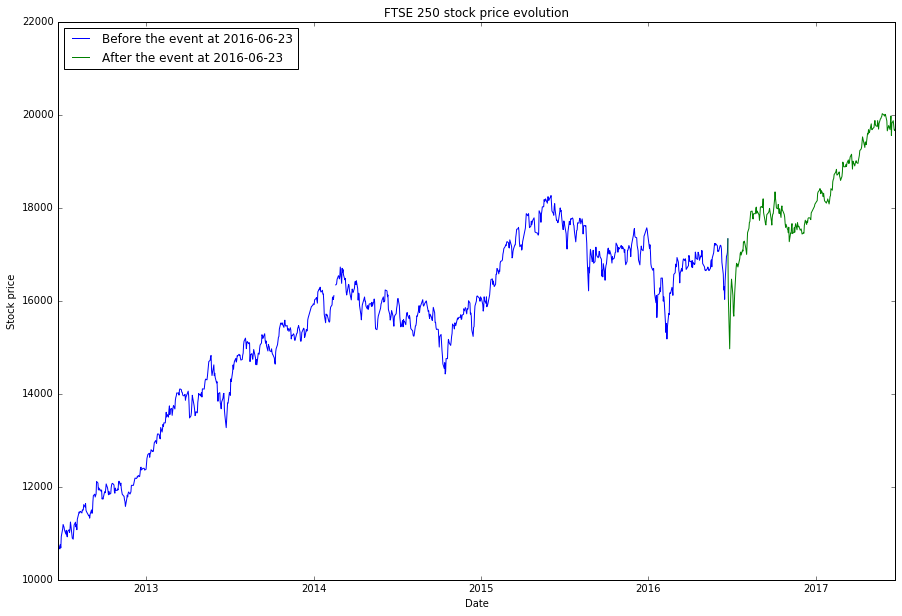

In [232]:
ts_ftse250 = getData('^FTMC', '2012-06-23', '2017-06-23', source='yahoo')
plotDataWithEvent(ts_ftse250,'2016-06-23','Date','Stock price','FTSE 250 stock price evolution')

### *In both plots, we can see that the 'Brexit' had indeed a visible effect right after the event. However, and contrary to poplar belief, the stock market has quickly recovered, continuing its ascendant rate of evolution. *

## Easy Jet

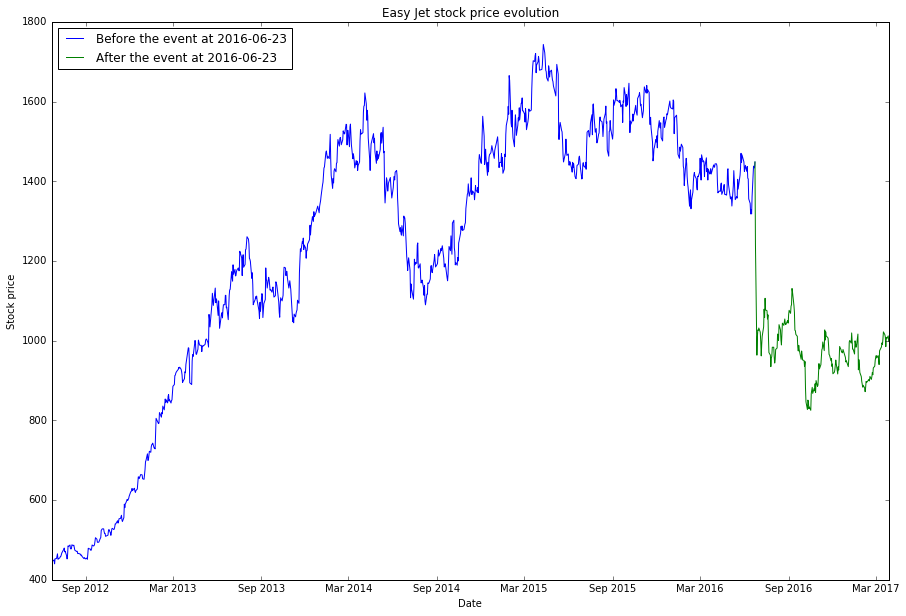

In [234]:
ts_easyjet = getData('EZJ.L', '2012-06-23', '2017-03-28', source='yahoo')
plotDataWithEvent(ts_easyjet,'2016-06-23','Date','Stock price','Easy Jet stock price evolution')

### *For Easy Jet, things are a little different. The company took a big hit after the Brexit. After some research, we found that the company is based in the UK and has only a UK and a Swiss air operator certificate. It must apply for an EU AOC to allow it to operate intra-European flights.*

# TRUMP ELECTION November 8th 2016

<img src="files/Images/Article-Trump.png">

## Let's analyze some stock market indices before and after Trump's election

## Nasdaq

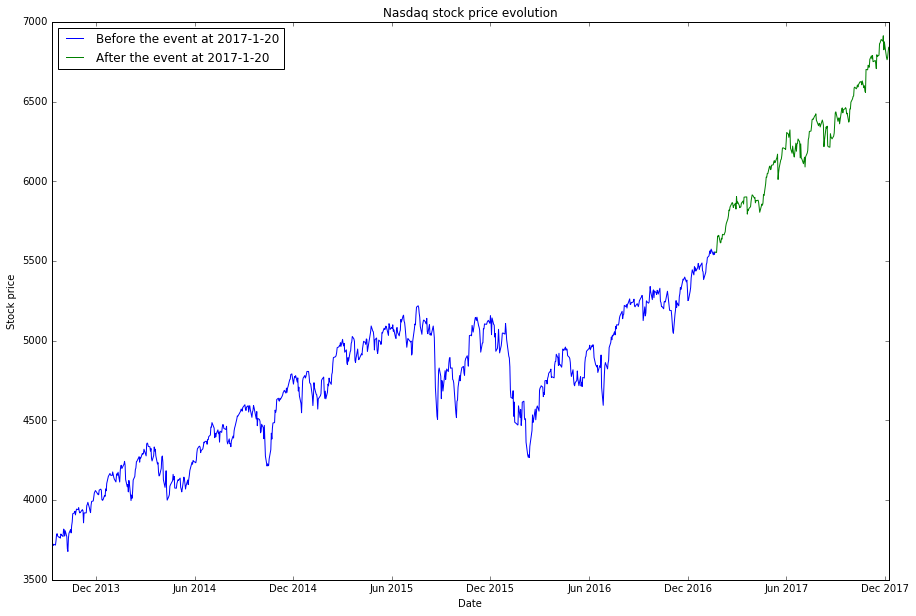

In [237]:
ts_nasdaq = getData('^IXIC', '2013-09-08', '2017-12-08', source='yahoo')
plotDataWithEvent(ts_nasdaq,'2017-1-20','Date','Stock price','Nasdaq stock price evolution')

### *We cannot see any visible influence of Trump's election on the Nasdaq index. It continued the steady ascent it was experiencing from before the election.*

## Oracle

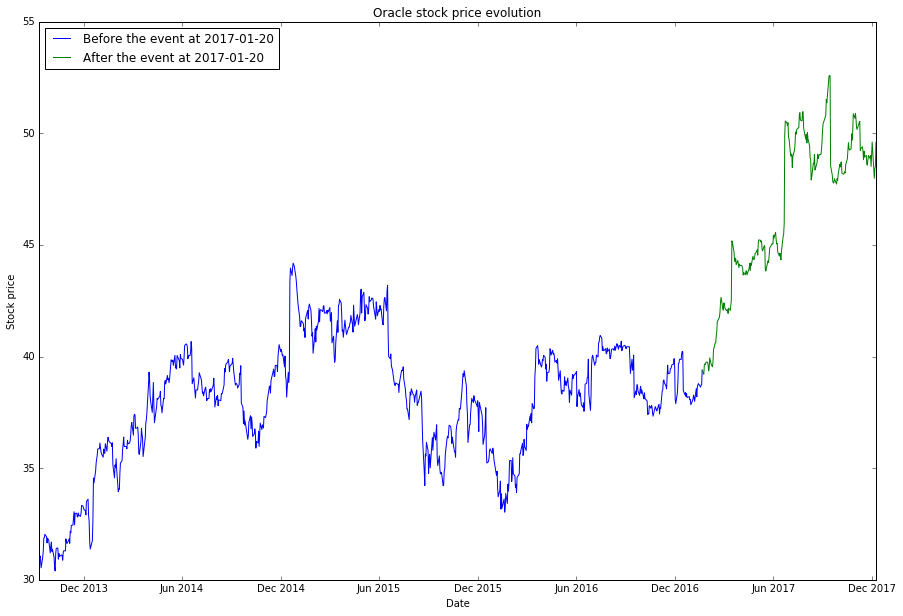

In [238]:
ts_oracle = getData('ORCL', '2013-09-08', '2017-12-08', source='yahoo')
plotDataWithEvent(ts_oracle,'2017-01-20','Date','Stock price','Oracle stock price evolution')

## *Oracle has clearly benefited from Trump's election. We can see an important uprise in their stock market. As a matter of fact, Oracle will save billions on its tax bill under Trump's tax holiday.*

## Hospital Corporation of America

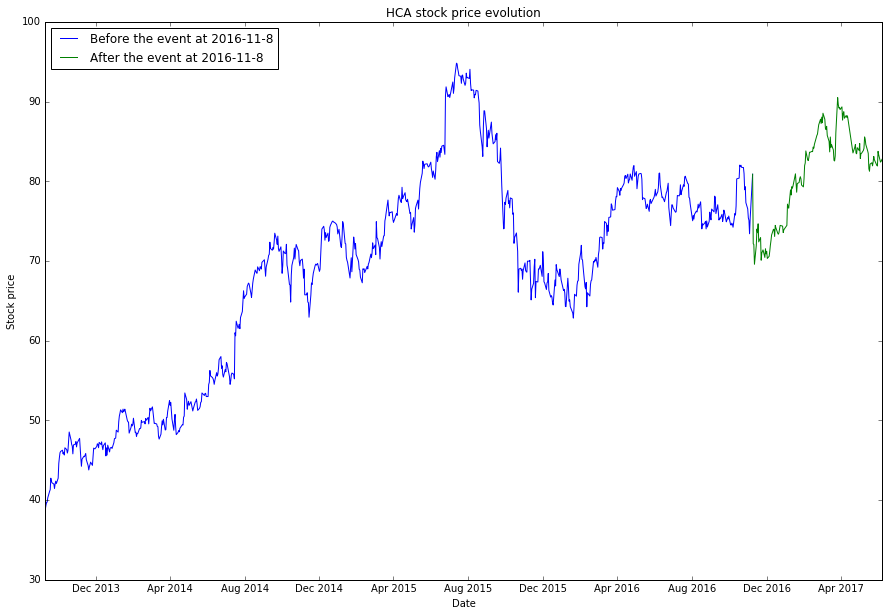

In [240]:
ts_hosp = getData('HCA', '2013-09-08', '2017-06-08', source='yahoo')
plotDataWithEvent(ts_hosp,'2016-11-8','Date','Stock price','HCA stock price evolution')

### *Hospitals have taken a relatively short-lived hit after Trump's election before their stock market started to recover. Trump's promise to stop funding the ObamaCare program meant that hospitals were bracing for an increase in unpaid medical bills.*